# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [48]:
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [49]:
components = nx.read_adjlist("../data/components.graph", create_using=nx.DiGraph())
absorbing = nx.read_adjlist("../data/absorbing.graph", create_using=nx.DiGraph())

In [270]:
def random_walk(G, iterations):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0:
            n = np.random.choice(neighbours)
        
    return pages_count / iterations

In [271]:
def print_page_counts(counts):
    for i in range(len(counts)):
        print(i, ':', counts[i])

In [273]:
iterations = 100000

print_page_counts(random_walk(components, iterations))

0 : 0.0
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.28568
5 : 0.14297
6 : 0.28568
7 : 0.28567


In [274]:
print_page_counts(random_walk(absorbing, iterations))

0 : 1e-05
1 : 0.99997
2 : 0.0
3 : 1e-05
4 : 1e-05


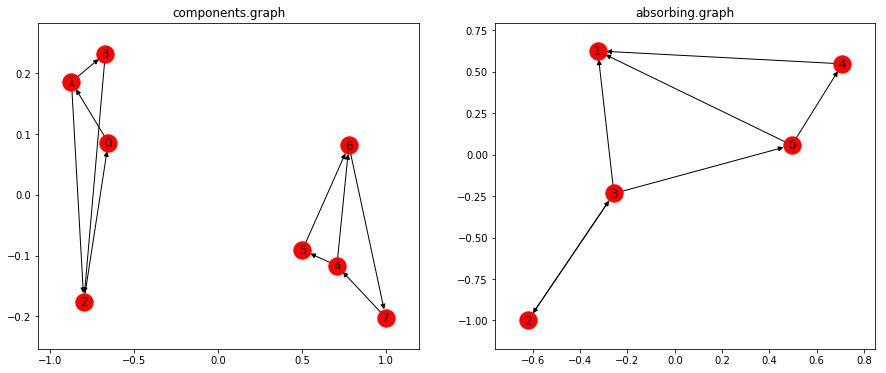

In [275]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("components.graph")
nx.draw_networkx(components, arrows=True)

plt.subplot(1,2,2)
plt.title("absorbing.graph")
nx.draw_networkx(absorbing, arrows=True)

### Explanation
The components graph has two separate connected components. Therefore the random surfer will never leave the component that it randomly selected at the start.<br>
The absorbing graph has (as its name says) an absorbing node (node 1). Once the random surfer reaches this node, it will never leave it again.

#### Exercise 2.13

In [276]:
def random_walk_teleportation(G, iterations, teleportation_prob=.15):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0 and np.random.rand(1) > teleportation_prob:
            n = np.random.choice(neighbours)
        else:
            n = np.random.choice(G.nodes())
        
    return pages_count / iterations

In [277]:
print_page_counts(random_walk_teleportation(components, iterations))

0 : 0.14109
1 : 0.13834
2 : 0.14351
3 : 0.07638
4 : 0.1391
5 : 0.0765
6 : 0.14383
7 : 0.14125


In the component with nodes 0 to 3, all nodes point to one other node, except for node 1 which points to node 2 and node 3. Therefore all surfers that visit node 1 will be splitted to two possible nodes. It could be expected that those two points will have lower rank. However, node 2 gets pointed to by more edges than the others. Therefore the big loser is node 3.<br>
Similarly in the second component.

In [278]:
print_page_counts(random_walk_teleportation(absorbing, iterations))

0 : 0.14989
1 : 0.33981
2 : 0.1465
3 : 0.21219
4 : 0.15161


Node 1 is the highest ranked. This makes sense, since it is pointed to by almost all other nodes.<br>
Node 3 comes second. While it has the same in-degree as most other nodes, it is the only one that 'inherits' all surfers from an other node (namely node 2 here).

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [79]:
wiki = nx.read_adjlist("../data/wikipedia.graph", create_using=nx.DiGraph())
titles= []
with open('../data/wikipedia_titles.tsv') as tsvfile:
    titles = list(csv.reader(tsvfile, delimiter='\t'))[1:]

In [59]:
def H(graph):
    H = np.zeros((graph.number_of_nodes(), graph.number_of_nodes()))
    edges = list(graph.edges)
    for u,v in edges:
        H[int(u)][int(v)] = 1 / len(list(graph.neighbors(u)))
    
    return H

In [60]:
def w(graph):
    nodes = list(graph.nodes)
    return np.array(list(map(lambda n : len(list(graph.neighbors(n))) < 1, nodes)))

In [281]:
def G(graph, damping=.15):
    N = graph.number_of_nodes()
    H_caret = H(graph) + np.ones((N, N)) * w(graph)[..., np.newaxis] / N
    return (1-damping) * H_caret + damping * np.ones((N, N)) / N
print(np.sum(G(wiki), axis=1))

[1. 1. 1. ... 1. 1. 1.]


In [305]:
def power_iterations(G, iterations=100):
    N = G.shape[1]
    pi = np.ones(N) / N
    
    for i in range(iterations):
        pi_t = np.dot(pi, G)
        pi_t /= np.linalg.norm(pi_t)
        if np.linalg.norm(pi_t - pi) < 1e-5:
            return pi_t
        pi = pi_t
    return pi

In [283]:
page_rank = power_iterations(G(wiki.copy()))

converged after 30 iterations


In [146]:
ranks = np.argsort(page_rank)[::-1]
for i in range(10):
    index = ranks[i]
    print(i+1, ':', titles[index][1])

1 : United States
2 : United Kingdom
3 : France
4 : Europe
5 : Germany
6 : England
7 : World War II
8 : Latin
9 : India
10 : English language


---

### 2.4.3 Gaming the system

#### Exercise 2.15

In [147]:
def find_index_of_title(title):
    for t in titles:
        if t[1] == title:
            return int(t[0])
    return -1

hist_math_index = find_index_of_title('History of mathematics')
hist_math_rank = int(np.where(ranks==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

node id: 2463 current ranking: 2530


We will iterate through the sorted page_rank list and add an edge from the most important pages to "History of mathematics" until 300 edges have been added (maybe there are already edges from the top 300 to "History of methematics", so we won't count those for our 300 added edges).

In [190]:
wiki_gamed = wiki.copy()
i = 0
e = len(list(wiki_gamed.in_edges('2463'))) + 300

# We are allowed to add 300 edges, so we keep adding from the best ranked sites until we got 300 new edges 
# (already existing don't count)
while len(list(wiki_gamed.in_edges('2463'))) < e:
    wiki_gamed.add_edge(str(ranks[i]), str(hist_math_index))
    i += 1

In [187]:
page_rank_gamed = power_iterations(G(wiki_gamed.copy()))

converged after 32 iterations


In [191]:
ranks_gamed = np.argsort(page_rank_gamed)[::-1]
for i in range(5):
    index = ranks_gamed[i]
    print(i+1, ':', page_rank_gamed[index], titles[index][1])

1 : 0.267252766835638 United States
2 : 0.18553442868365722 United Kingdom
3 : 0.18024661325885102 France
4 : 0.1693971853618579 History of mathematics
5 : 0.16053692843263198 Europe


We got from rank 2530 to rank 4. Pretty good, but let's try better.<br>
What if the best ranked pages aren't the best endorsers, because they have many out-links?<br>
We divide the ranks by the number of outgoing links of the respective nodes, sort the array again and take the 300 best endorsers again.

In [221]:
page_rank_gamed2 = page_rank.copy()
nodes2 = list(wiki_gamed.nodes)
for i in range(len(page_rank_gamed)):
    neighs = len(list(wiki_gamed.neighbors(nodes2[i])))
    if neighs != 0:
        page_rank_gamed2[i] /= neighs

In [246]:
ranks2 = np.argsort(page_rank_gamed2)[::-1]
wiki_gamed = wiki.copy()
i = 0
e = len(list(wiki_gamed.in_edges('2463'))) + 300

while len(list(wiki_gamed.in_edges('2463'))) < e or i >= wiki_gamed.number_of_nodes():
    wiki_gamed.add_edge(str(ranks2[i]), str(hist_math_index))
    i += 1

In [247]:
page_rank_gamed = power_iterations(G(wiki_gamed.copy()))

converged after 32 iterations


In [248]:
ranks_gamed = np.argsort(page_rank_gamed)[::-1]
for i in range(10):
    index = ranks_gamed[i]
    print(i+1, ':', titles[index][1])

1 : United States
2 : United Kingdom
3 : France
4 : Europe
5 : Germany
6 : England
7 : World War II
8 : Latin
9 : History of mathematics
10 : India


Well that didn't work out very vell, did it?

In [245]:
import operator

# Verify with networx implementation
pr = nx.pagerank(wiki_gamed.copy())

sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
sorted_pr.reverse()
for i in range(10):
    index = int(sorted_pr[i][0])
    print(i+1, ':', titles[index][1])

1 : United States
2 : United Kingdom
3 : France
4 : Europe
5 : Germany
6 : England
7 : World War II
8 : Latin
9 : History of mathematics
10 : India


In [341]:
def improvement_when_adding_edge(graph, ranks_before, u, v, node):
    if u == v:
        return -1
    graph.add_edge(u, v)
    ranks_new = power_iterations(G(graph))
    return ranks_new[int(node)] - ranks_before[int(node)]

In [ ]:
def find_new_edge_with_highest_impact(graph, node):
    ranks_before = power_iterations(G(graph))
    sorted_ranks = np.argsort(ranks_before)[::-1]
    neighbors = list(graph.neighbors(node))
    sorted_neighbors = []
    
    for i in range(len(sorted_ranks)):
        if str(i) in neighbors:
            sorted_neighbors.append(str(i))
    sorted_neighbors = sorted_neighbors[::-1]
    
    impact = -1, 0, 0
    i = 0
    while i < len(sorted_ranks):
        n = str(sorted_ranks[i])
        i += 1
        if not graph.has_edge(n, node):
            d = improvement_when_adding_edge(graph.copy(), ranks_before, n, node, node)
            if d > impact[0]:
                return n, node
            else:
                i -= 1
                print('yay!!!')
                return impact[1], impact[2]
        
        j = 0
        found = False
        while j < len(sorted_neighbors) and not found:
            neighbor = str(sorted_neighbors[j])
            j += 1
            if not graph.has_edge(n, neighbor):
                found = True
                d = improvement_when_adding_edge(graph.copy(), ranks_before, n, neighbor, node)
                if d > impact[0]:
                    impact = d, n, neighbor
                
    return None, None

In [ ]:
wiki_gamed3 = wiki.copy()
added_edges = 0
while added_edges < 300:
    u, v = find_new_edge_with_highest_impact(wiki_gamed3, '2463')
    if not u or not v:
        print('fail')
    wiki_gamed3.add_edge(u,v)
    print(added_edges, 'added', u, v)
    added_edges += 1

0 added 5210 2463
1 added 5201 2463
2 added 2034 2463
3 added 1890 2463
4 added 2168 2463
